### 2. АНАЛИЗ МОДЕЛЕЙ ПРОГНОЗИРОВАНИЯ НА ОСНОВЕ ДАННЫХ ЦЕНЫ НА АКЦИИ КОМПАНИИ СБЕРБАНК

### В ходе данной работы были реализованы следующие модели: линейная регрессия методом наименьших квадратов, авторегрессионная модель ARCH и метод возращения к среднему значению.

In [ ]:
import pandas as pd, math, numpy as np, datetime as dt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import linear_model

from sklearn.linear_model import Ridge

from arch import arch_model

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


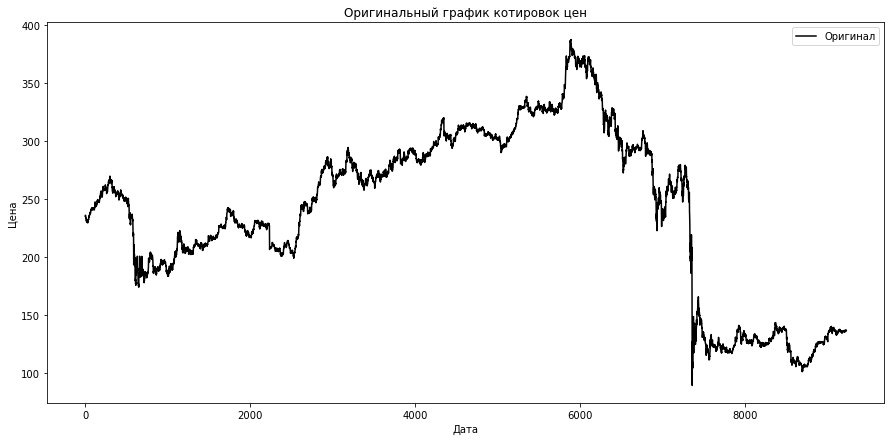

Y_LIN
r2_score:  -2.318006536187205
mae:  99.61390439074354
mse:  11394.118031666965
Y_RIDGE
r2_score:  -2.3180065367420504
mae:  99.61390439820123
mse:  11394.118033572317
Y_ARCH
r2_score:  0.9977631899372321
mae:  1.5905016889072006
mse:  7.681262104710846
Y_MEAN
r2_score:  0.9956166538024823
mae:  1.760265089722675
mse:  15.052521266449158


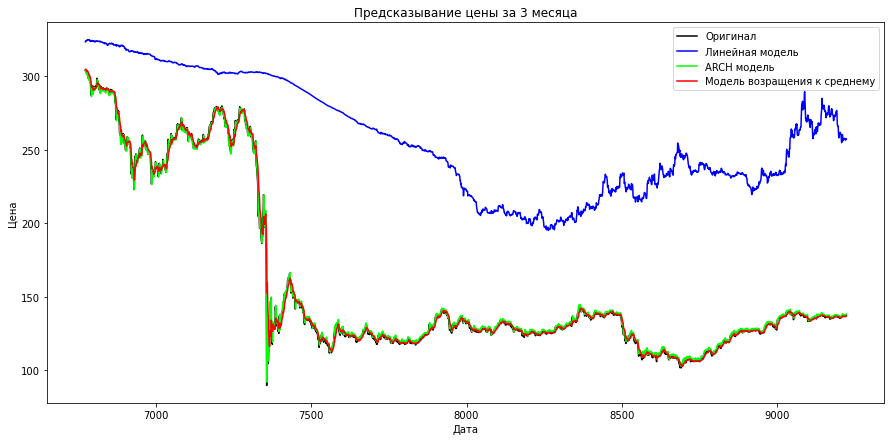

In [4]:
def get_param(name,real,predict):
    print(name.upper())
    print('r2_score: ', r2_score(real, predict))
    print('mae: ', mae(real, predict))
    print('mse: ', mse(real, predict))
    #print('rmse: ', math.sqrt(mse(real, predict)))
    return 1

def predict_plots(df):
    fig, ax = plt.subplots()    
    df= df[median+window:]    
    ax.plot(df['close'], color = 'black',label = 'Оригинал')
    ax.plot(df['y_lin'],color = 'b', label = 'Линейная модель')
    ax.plot(df['y_arch'],color = 'lime', label = 'ARCH модель')
    ax.plot(df['y_mean'],color = 'red', label = 'Модель возращения к среднему')
    ax.legend()
    fig.set_figheight(7)
    fig.set_figwidth(15)
    plt.title('Предсказывание цены за 3 месяца')
    ax.set_xlabel('Дата',fontsize = 10,    color = 'black')    
    ax.set_ylabel('Цена',fontsize = 10,    color = 'black')    
    #plt.savefig('foo.png')
    plt.show()
    return 1
        
def get_arch_model(df):
    all_lst = df['close'].tolist()
    df['y_arch'] = np.zeros(df.shape[0])
    for i in range(1,len(all_lst)):
        
        #x = all_lst[i]
        #del all_lst[i]    
        #new_lst = np.array(all_lst[:])
        new_lst=np.array(all_lst[i+1:]+all_lst[:i]) 
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')        
            model = arch_model(new_lst, vol = 'ARCH', mean = 'Zero') 
            model_fit = model.fit(disp = 'off') #disp='off'
       
        yhat = model_fit.forecast(reindex = False)
        dis = float(yhat.variance.values[-1,:])
        #print(dis**0.5)
        y_pred_a = dis**0.5
        df['y_arch'][i] = y_pred_a
        #all_lst.insert(i,x)
    return df

def get_mean_model(df):
    all_lst = df['close'].tolist()
    new_y_pred = [all_lst[0]]
    for i in range(1,len(all_lst)):  
        if i < 10:
            mean_ = np.mean(all_lst[:i])
        else:
            mean_ = np.mean(all_lst[i-10:i])
       
        ny_pred = mean_ + ((all_lst[i-1] - mean_) / 3) #+ np.sign(all_lst[i-1] - mean_) * random.uniform(0, 0.01)        
        new_y_pred.append(ny_pred)
    df['y_mean'] = new_y_pred
    return df

def get_predict(df):
    df['y_lin'] = np.zeros(df.shape[0])
    df['y_ridge'] = np.zeros(df.shape[0])
    
    x_list = []#[df1['ewm_funding_rate'][:median],df2['ewm_funding_rate'][:median]]
    for t in range(median):
        x_list.append([df['close'][t]])
    y_list = df['close'][window:median+window].tolist()
    all_pred, all_real = [], []

    for i in range(median, df.shape[0] - window):

        new_x = [[df['close'][i]]]
        y_real = df['close'][i+window]

        x = np.array(x_list).reshape(-1,1)
        y = np.array(y_list)

        lmodel = LinearRegression(normalize='deprecated').fit(x, y)
        rmodel = linear_model.Ridge(alpha=0.01,max_iter = 1000,tol=0.0001).fit(x, y)

        y_pred_l = lmodel.predict(np.array(new_x).reshape((-1, 1)))
        y_pred_r = rmodel.predict(np.array(new_x).reshape((-1, 1)))

        x_list.append([df['close'][i]])
        y_list.append(df['close'][i+window])

        df['y_lin'][i+window] = y_pred_l
        df['y_ridge'][i+window] = y_pred_r
    
    return df

def get_image(df):
    fig, ax = plt.subplots()
    ax.plot(df['close'], color = 'black',label = 'Оригинал')  
    ax.legend()
    fig.set_figheight(7)
    fig.set_figwidth(15)
    plt.title('Оригинальный график котировок цен')
    ax.set_xlabel('Дата',fontsize = 10,    color = 'black')    #  цвет шрифта
    ax.set_ylabel('Цена',fontsize = 10,    color = 'black')    #  цвет шрифта
    #plt.savefig('foo.png')
    plt.show()
    return 1

if __name__ == '__main__':
    window = 2160
    df = pd.read_csv("C:/Users/ZuZu/Documents/DA2/SBER_191201_221201.txt",sep=',')
    df.columns = ['date','time','open','high','low','close','vol']
    df.loc[(df['time'] == 0), 'time'] = '000000'
    df['ttime'] = pd.to_datetime(df['time'], format='%H%M%S')
    df = df.set_index(df['ttime'])
    df['time'] = df.index.time #df['date'] + df['ttime'].astype('str')
    df.reset_index(inplace=True,drop=True)
    df = df.drop(columns = ['ttime'])
    df['date'] =  pd.to_datetime(df['date'])
    df['exchange time']= df["date"].astype(str) + " " + df["time"].astype(str)
    df['exchange time'] = pd.to_datetime(df['exchange time'])
    get_image(df)
   
    
    #df['price_dif'] = df['close']-df['close'].shift()
    #df = df[1:]
    #df.reset_index(inplace=True)
    ##df = df.set_index(df['exchange time'])
    #df = df[:int(df.shape[0]/2)]    
    median = int(df.shape[0] / 2)
    df = get_predict(df)
    df = get_arch_model(df)
    df = get_mean_model(df)
    for i in ['y_lin','y_ridge','y_arch','y_mean']:
        real = df['close'][median+window:].tolist()
        predict = df[i][median+window:].tolist()
        get_param(i,real,predict)
    predict_plots(df)
   

### Вывод: Исходя из результатов, можно сказать, что за 24 и 48 часов все 3 модели хорошо справились с прогнозированием цены, о чем говорит показатель детерминации, который равен 0,97-0,99. Однако при прогнозировании цены, которая будет через 1-3 месяца линейная модель не может корректно предсказать значение. Остальные модели хорошо предсказывают данные даже на более длительный период.